# Problem Set 06: 

0. [Credit for Contributors (required)](#contributors)

1. [RRT Path Planning (100 points)](#problem1)
    1. [Complete the RRT code (50 points)](#rrt)
    2. [Test your code on simple environment (20 points)](#simple_env_code)
    2. [Test your code on given environments (20 points)](#bugtrap_env_code)
    3. [Test your code on harder and random environments (10 points)](#hard_env_code)

    
**100 points** total for Problem Set 6

## <a name="contributors"></a> Credit for Contributors

List the various students, lecture notes, or online resouces that helped you complete this problem set:

Ex: I worked with Bob on the cat activity planning problem.

<div class="alert alert-info">
Write your answer in the cell below this one.
</div>

Worked with Anoop to fix Shapley issue and a personal issue I had using import check_path twice. Used Anoop's motion planning slides to build the rrt algorithm. Worked with Shashank to help formulate what the edges and vertices should be (lists, dicts, etc.) and helped me understand how to calculate x_new.

## <a name="problem1"></a> Problem 1 : RRT Path Planning

In this problem you will implement the Rapidly-Exploring Random Tree (RRT) algorithm to help a robot navigate from its starting position to the desired end region in an environment full of obstacles.

<img src='rrt_examples.png'/>

You will implement the function `rrt` with the following signature:

```python
def rrt(bounds, environment, start_pose, radius, end_region)
```

where:

- `bounds=(minx, miny, maxx, maxy)` is a tuple that indicates the bounds of the environment (the region the robot can traverse). Example `bounds=(-5, -4, 15, 5)`.
- `environment` is an instance of the `Environment` class that describes the placement of the obstacles in the scene (see more examples below).
- `start_pose = (x,y)` is a tuple indicating the starting position of the robot. Example: `start_pose=(-4, -2)`.
- `radius` is the radius of the robot (used for collision checking). Example `radius=0.1`.
- `end_region` is a `shapely` `Polygon` that describes the region that the robot needs to reach. See examples below.

Your function should:

- return a list of tuples `(x, y)` describing the obstacle free path that takes the robot to the target region. Example of a valid returned path: `[(-4, -2), (-3.71, -1.97), (-3.41, -1.8865), (-3.50, -2.69)]`. Note that your rrt function should produce paths such that the straight line connecting any pair of consecutive points should be obstacle free (considering the obstacles and the size of the robot). In the given example, it should be possible to go from `(-4, -2)` to `(-3.71, -1.97)` in a straight line without colliding with anything.
- produce a plot showing the tree and the obstacle free path (such as the ones shown above)
- show the number of nodes in the tree, the number of nodes in the solution path and the path length (you could put this in the plot title, as in the examples above)


**You are required to submit this notebook with:**

1. The code function `rrt` as described above
2. The results (plots) of using your `rrt` function in the easy and bugtrap environments provided (see code stubs below).
3. The results of using your `rrt` function in a challenging (600 obstacles) environment that is provided.

See the provided example notebook [RRT Helpful Examples](ProblemSet06_RRT_examples.ipynb) for examples on how to use the `Environment` class, the `shapely` library, and how to do some simple collision checking.


<div class="alert alert-info">
**NOTE:** You don't need to write all your code in this notebook if you don't want to. You could create your own `.py` files and then import them into this notebook. We do require that we are able to run the two environments that we provide and the two that you generate in this notebook and that the plots are embedded here.
</div>


<div class="alert alert-warning">
Please ensure that you submit your notebook with the cells already executed. That is, you should save the notebook when your code has been executed and the plots are visible. That way, we will be able to look at your solution initially without running your code first.
</div>



In [1]:
!pip install shapely==1.8.3

In [2]:
# Useful imports
%load_ext autoreload
%autoreload 2
%matplotlib inline
from __future__ import division
import yaml
import numpy as np
from check_path import check_path
from matplotlib import pyplot as plt
from shapely.geometry import Point, Polygon, LineString, box
from environment import Environment, plot_environment, plot_line, plot_poly

In [3]:
# Write your RRT code here (this cell and below)!
# Note that you can write your code in separate .py files
# and import them here later if you prefer

# YOUR CODE HERE
import random
import math
import time
import pdb
#from tqdm import tqdm

def distance(a,b):
    return math.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)

def random_x(bounds):
    random_x = random.uniform(bounds[0], bounds[2]) #within min x and max x
    random_y = random.uniform(bounds[1], bounds[3]) #within min y and max y
    return (random_x,random_y)

def find_x_nearest(Vertices,x_rand):
    for j in range(len(Vertices)):
        if j == 0:
            dist_min = distance(Vertices[j],x_rand)
            node_min = Vertices[j]
        else:
            dist = distance(Vertices[j],x_rand)
            if dist < dist_min:
                dist_min = dist
                node_min = Vertices[j]
                
    return node_min, dist_min  


def find_x_new(x_nearest,x_rand,d,bounds):
    dist = distance(x_nearest,x_rand)
      #if dist <= d: # no need for unit vector math if dist is already within tolerance
          #return x_rand
      #else:
    unit_x = (x_rand[0]-x_nearest[0])/dist #make unit vector for direction
    unit_y = (x_rand[1] - x_nearest[1])/dist #make unit vector for direction
    #cut_x = d*(x_rand[0]-x_nearest[0]) #desired x magnitude based of percent of distance
    #cut_y = d*(x_rand[1]-x_nearest[1]) #desired y magnitude based of percent of distance
    #x_new_x = cut_x*unit_x #magntitude x direction for x_new
    #x_new_y = cut_y*unit_y #magntitude x direction for x_new
    x_new_x = x_nearest[0]+d*unit_x #add unit vector*d to x_nearest to make x_new
    x_new_y = x_nearest[1]+d*unit_y #add unit vector*d to make x_neww
    if bounds[0] <= x_new_x <= bounds[2] and bounds[1] <= x_new_y <= bounds[3]:
        return (x_new_x,x_new_y) # point is within the boundary
    else:
        while not (bounds[0] <= x_new_x <= bounds[2] and bounds[1] <= x_new_y <= bounds[3]): 
            d = 0.9*d
            x_new_x = x_nearest[0]+d*unit_x #add unit vector*d to x_nearest to make x_new
            x_new_y = x_nearest[1]+d*unit_y #add unit vector*d to make x_neww
            
        return (x_new_x,x_new_y)
        
    #pdb.set_trace()
    
  
def collision_check(x_nearest,x_new,environment,radius):
    # Define the start and end poses
    # and the radius of the ball
    #start_pose = Point(x_nearest).buffer(radius, resolution=3)
    #end_pose = Point(x_new).buffer(radius, resolution=3)
    
    # Line that connects the start to the end
    line = LineString([x_nearest, x_new])
    
    # "Buffer" the line by the radius amount
    # This expands the line and creates a polygonal approximation
    # We can use this to test for collisions
    expanded_line = line.buffer(radius, resolution=3)
    
    for i, obs in enumerate(environment.obstacles):
    # Check collisions between the expanded line and each obstacle
        if expanded_line.intersects(obs):
            return True
    
    return False
    
    #print("Expanded line intersects obstacle %d? " % i,expanded_line.intersects(obs))
    # Checks to see if a point is inside each obstacle
    #print("Point (3.5, 1) inside obstacle %d? " % i,obs.contains(Point((3.5,1))))
def find_rrt_path(start,x_new,Edges):
    rrt_path = [x_new]
    current_node = x_new
    while current_node != start:
        if current_node in Edges.keys():
            next_node = Edges[current_node]
            rrt_path.append(next_node)
            current_node = next_node
    return rrt_path

def plot_rrt(start,goal_region,Edges,environment,bounds,rrt_path,duration,radius):
    ax = plot_environment(environment, bounds=bounds)
    start_point = Point(start)
    start_ball = start_point.buffer(radius, resolution=3)
    plot_poly(ax, start_ball,'magenta')
    plot_poly(ax, goal_region,'green')
    
    for key, value in Edges.items(): # plot all branches of the tree
        node1 = key
        node2 = value
        if value != []:
            line = LineString([node1,node2])
            #expanded_line = line.buffer(0.5, resolution=3)
            # Draw the original line
            plot_line(ax, line)
            # Draw the expanded line
            #plot_poly(ax, expanded_line, 'green', alpha=0.2)
    #pdb.set_trace()        
    dist = 0
    for i in range(len(rrt_path)-1):
        dist = dist + distance(rrt_path[i],rrt_path[i+1])
        line = LineString([rrt_path[i],rrt_path[i+1]])
        expanded_line = line.buffer(radius, resolution=3)
        plot_poly(ax, expanded_line, 'magenta', alpha=0.2)
        title = f"{len(Edges)-1} tree nodes. {duration:.3f} seconds. {len(environment.obstacles)} obstacles. Path Length: {dist:.1f} ({len(rrt_path)} nodes)"
        ax.set_title(title) 

def plot_no_rrt(start,goal_region,Edges,environment,bounds,duration,radius):
    ax = plot_environment(environment, bounds=bounds)
    start_point = Point(start)
    start_ball = start_point.buffer(radius, resolution=3)
    plot_poly(ax, start_ball,'magenta')
    plot_poly(ax, goal_region,'green')
    
    for key, value in Edges.items(): # plot all branches of the tree
        node1 = key
        node2 = value
        if value != []:
            line = LineString([node1,node2])
            #expanded_line = line.buffer(0.5, resolution=3)
            # Draw the original line
            plot_line(ax, line)
            # Draw the expanded line
            #plot_poly(ax, expanded_line, 'green', alpha=0.2)
        title = f"{len(Edges)-1} tree nodes. {duration:.3f} seconds. {len(environment.obstacles)} obstacles.)"
        ax.set_title(title) 
    #pdb.set_trace()                             

def rrt(bounds, environment, start, radius, goal_region):
    start_time = time.time()
    N = 50000
    d = 1 # the percent i want to take off my x_rand to x_new (so half the distance for example)
    #start = np.array([start])
    Vertices = [start] #create list of vertices
    Edges = {} # create dict mappoing vertices to other vertices i.e. edges
    Edges[start] = [] # first set in the dict is start with no edge
    #for i in tqdm(range(N)):
    for i in range(N):
        print(f"\rCurrent value of i: {i}", end="")
        #Note, could add goal biasing here to generate random point
        #pdb.set_trace()
        x_rand = random_x(bounds) # generate random number within boundary (x_rand)
        x_nearest, dist_min = find_x_nearest(Vertices,x_rand) # Find x_nearest existing node
        x_new = find_x_new(x_nearest,x_rand,d,bounds) # Find x_new closer along the same line
        
        #check for collisions
        if collision_check(x_nearest,x_new,environment,radius) == False:
            Vertices.append(x_new) #add x_new to set of nodes
            Edges[x_new] = x_nearest #add x_new x_nearest edge to dict
        
        #check to see if x_new is in goal region
       #if i == 999:
            #pdb.set_trace()
        if goal_region.contains(Point(x_new)) == True:
            #pdb.set_trace()
            rrt_path = find_rrt_path(start,x_new,Edges)
            
            end_time = time.time()
            duration = end_time - start_time
            #pdb.set_trace()
            plot_rrt(start,goal_region,Edges,environment,bounds,rrt_path,duration,radius)
            end_time = time.time()
            duration = end_time - start_time
            final_path = rrt_path[::-1]
            return final_path
    
    end_time = time.time()
    duration = end_time - start_time
    plot_no_rrt(start,goal_region,Edges,environment,bounds,duration,radius)    
    print('No Path Found') # if this happens increase N, maybe add goal biasing


<a name="simple_env_code"></a> **Test your code on the simple environment (20 points)**

Current value of i: 369(7.0, 5.5)


Path seems to be correct. 
 However, collisions are not checked. Make sure your path doesn't collide with any obstacles.

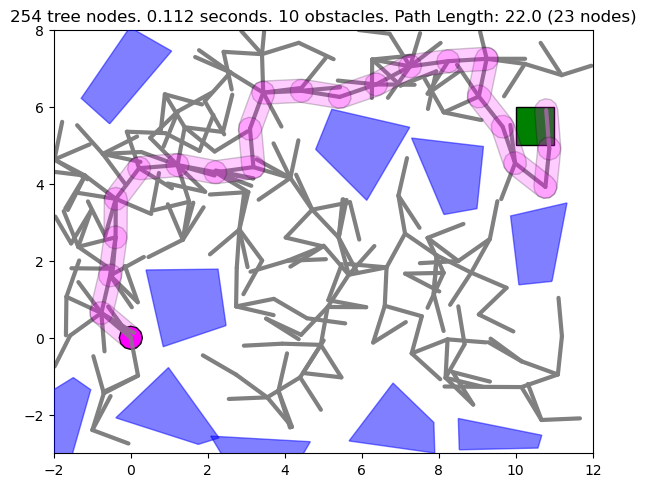

In [5]:
# Test your code in the simple environment
# don't modify this cell. It will be overwritten by the autograder.
# if you want to test things, please create additional cells at the end
environment = Environment('simple.yaml')
radius = 0.3
bounds = (-2, -3, 12, 8)
start = (0, 0)
goal_region = Polygon([(10,5), (10,6), (11,6), (11,5)])
path = rrt(bounds, environment, start, radius, goal_region)
# The check path function checks that the path is a list,
# its elements are tuples and the start and end are correct
# It doesn't check collisions.
check_path(path, bounds, environment, start, radius, goal_region)

<a name="bugtrap_env_code"></a> **Test your code on the bugtrap environment (20 points)**

Current value of i: 574(7.0, 5.5)


Path seems to be correct. 
 However, collisions are not checked. Make sure your path doesn't collide with any obstacles.

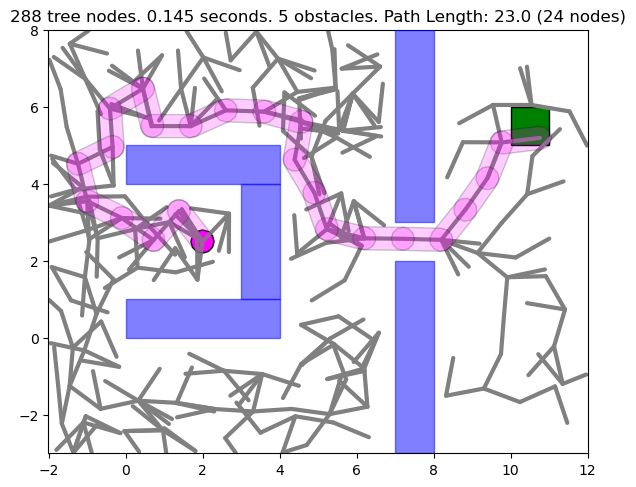

In [6]:
# Test your code in the bugtrap environment
# don't modify this cell. It will be overwritten by the autograder.
# if you want to test things, please create additional cells at the end
environment = Environment('bugtrap.yaml')
radius = 0.3
bounds = (-2, -3, 12, 8)
start = (2, 2.5)
goal_region = Polygon([(10,5), (10,6), (11,6), (11,5)])
path = rrt(bounds, environment, start, radius, goal_region)
# The check path function checks that the path is a list,
# its elements are tuples and the start and end are correct
# It doesn't check collisions.
check_path(path, bounds, environment, start, radius, goal_region)

<a name="hard_env_code"></a> **Test your code on the harder environment that we have provided (10 points)**

(-5, -4, 15, 5)
(11.995705476092299, 5.5)


<AxesSubplot:>

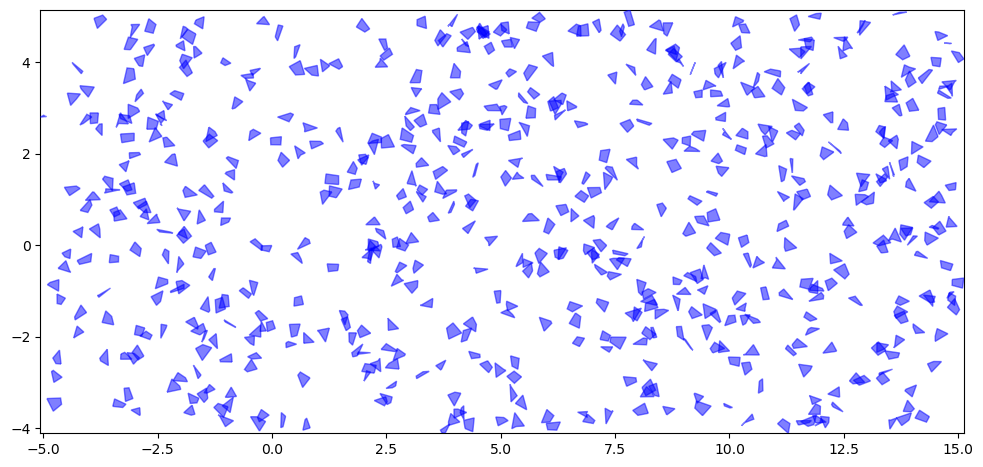

In [7]:
def random_environment(bounds, start, radius, goal, n, size_limits=(0.5, 1.5)):
    minx, miny, maxx, maxy = bounds
    print(bounds)
    edges = 4
    minl, maxl = size_limits
    env = Environment(None)
    obs = []
    start_pose = Point(start).buffer(radius, resolution=3)
    obi = 0
    while obi < n:
        r = np.random.uniform(low=0.0, high=1.0, size=2)
        xy = np.array([minx + (maxx-minx)*r[0], miny + (maxy-miny)*r[1]])
        
        angles = np.random.rand(edges)
        angles = angles*2*np.pi / np.sum(angles)
        for i in range(1,len(angles)):
            angles[i] = angles[i-1] + angles[i]
        angles = 2*np.pi * angles / angles[-1] 
        angles = angles + 2*np.pi*np.random.rand()
        lengths = 0.5*minl + (maxl-minl) * 0.5 * np.random.rand(edges)
        xx = xy[0] + np.array([l*np.cos(a) for a,l in zip(angles,lengths)])
        yy = xy[1] + np.array([l*np.sin(a) for a,l in zip(angles,lengths)])
        p = Polygon([(x,y) for x,y in zip(xx,yy)])
        if p.intersects(start_pose) or p.intersects(goal):
            continue
        else:
            obi = obi + 1
            obs.append(p)
#         coords = xy + [l*np.cos(a),l*np.sin(a) for a,l in zip(angles,lengths)]
    env.add_obstacles(obs)
    return env


start = (-4,-2)
radius = 0.1  
goal_region = Polygon([(12,3), (12,4), (13,4),(13,3)])
bounds = (-5, -4, 15, 5)
env = random_environment(bounds, start, radius, goal_region, 600, (0.2, 0.4))
plot_environment(env)

In [8]:
env.save_to_yaml('challenging600.yaml')

Current value of i: 7014(12.222222222222221, 5.5)


Path seems to be correct. 
 However, collisions are not checked. Make sure your path doesn't collide with any obstacles.

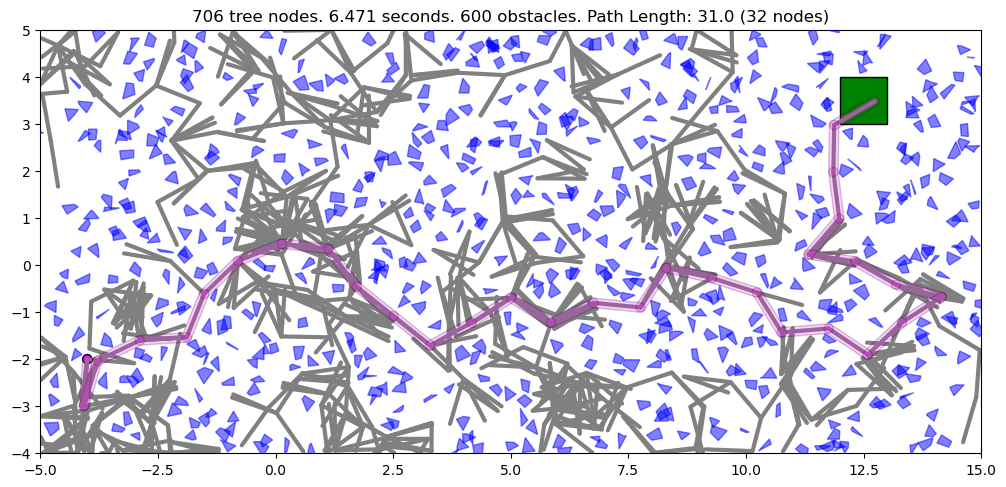

In [10]:
# Test your code in the challenging environment that you made
environment = Environment('challenging600.yaml')
# radius = 0.2
# bounds = (-2, -3, 12, 8)
# start = (2, 2.5)
# goal_region = Polygon([(10,5), (10,6), (11,6), (11,5)])
path = rrt(bounds, environment, start, radius, goal_region)
# The check path function checks that the path is a list,
# its elements are tuples and the start and end are correct
# It doesn't check collisions.
check_path(path, bounds, environment, start, radius, goal_region)